# Relatório

Fusão de Informação em Análise de Dados - Projeto I

Alunos: Gabriel Grangeia e Ingrid Nogueira



# Código

Importações

In [ ]:
!pip install filterpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=6bd7adb33576c17504ad4d6fb5d94ce62f6a76b6448bb4ca491bf5629c2253ba
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.transform import Rotation as Rot
import scipy.linalg
from scipy.linalg import sqrtm, inv
import scipy.stats
from filterpy.monte_carlo import systematic_resample
from numpy.random import uniform, randn
from numpy.linalg import norm


1. Criar uma função que implementa o modelo dinâmico do robot;

In [ ]:
def modelo_dinamico(x, u):
    A = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
    ])

    B = np.array([
        [np.cos(x[2])[0] * dt, 0],
        [np.sin(x[2])[0] * dt, 0],
        [0, dt],
        [1, 0],
    ])
    # matriz A é identidade para os valores de x, y e phi. 0 para o valor de 'v'
    # matriz B é para aplicar as entradas de controle ao estado atual
    x = A @ x + B @ u
    #vetor x representa o estado atual do robot
    return x

2. Criar uma função que implementa o modelo de observação;

In [ ]:
def modelo_observacao(x):
    C = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ], dtype=float)

    # matriz C é a matriz de observação (dimensao 2x4)
    # vetor z contem as posicoes estimadas em x e y observadas pelo sensor
    z = C @ x
    return z

3. Criar uma função que representa a aquisição de dados dos sensores;

In [ ]:
def aquisicao_dados(xTrue, xd, u, efk=True):
    if efk:
        xTrue = modelo_dinamico(xTrue, u) #atualização do estado verdadeiro

        # adiciona ruido GPS x-y
        zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
        zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
        z = np.array([[zx, zy]]) #observacao com ruido

        # adiciona ruido ao input (comandos de controle)
        ud1 = u[0, 0] + np.random.randn() * Input_Noise[0, 0]
        ud2 = u[1, 0] + np.random.randn() * Input_Noise[1, 1]
        ud = np.array([[ud1, ud2]]).T

        xd = modelo_dinamico(xd, ud) #atualização do estado estimado

        return xTrue, z, xd, ud

    else:
        xTrue = modelo_dinamico(xTrue, u)

        # adiciona ruido gps x-y
        z = modelo_observacao(xTrue) + GPS_Noise @ np.random.randn(2, 1)

        # adiciona ruido ao input
        ud = u + Input_Noise @ np.random.randn(2, 1)

        xd = modelo_dinamico(xd, ud)

        return xTrue, z, xd, ud

4. Criar uma função que implementa o Extended Kalman Filter (EKF);

In [ ]:
def ekf_estimativa(xEst, PEst, z, u):
    def jacobA(x, u):
        v = u[0][0]
        phi = x[2][0]
        return np.array([
            [1, 0, -v * np.sin(phi) * dt, np.cos(phi) * dt],
            [1, 0, v * np.cos(phi) * dt, np.sin(phi) * dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ], dtype=float)

    def jacobC(x):
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ], dtype=float)

    # Previsão
    xPred = modelo_dinamico(xEst, u)
    pPred = jacobA(xEst, u) @ PEst @ jacobA(xEst, u).T + Q

    # Atualização
    jacobiana = jacobC(xPred) #matriz C linearizada
    zPred = modelo_observacao(xEst) #observacoes previstas usando estado previsto
    y = z.T - zPred # real Z - previsao zPred
    S = jacobiana @ pPred @ jacobiana.T + R #covariancia do resíduo
    S = S.astype(float)
    S_inv = np.linalg.inv(S)
    K = pPred @ jacobiana.T @ S_inv #ganho de kalman
    xEst = xPred + K @ y #estado estimado (corrige o estado previsto com base nas medicoes)
    PEst = (np.eye(len(xEst)) - K @ jacobiana) @ pPred # covariancia estimada do estado (atualizada após a incorporação de nova medida)

    return xEst, PEst

5. Criar uma função que implementa o Unscented Kalman Filter (UKF);

In [ ]:
def setup_ukf(nx): #inicialização dos parâmetros críticos do UKF
    # calcula lambda
    # nx dimensao do vetor
    lamb = ALPHA ** 2 * (nx + KAPPA) - nx
    # calcula os pesos
    wm = [lamb / (lamb + nx)]
    wc = [(lamb / (lamb + nx)) + (1 - ALPHA ** 2 + BETA)]
    for i in range(2 * nx):
        wm.append(1.0 / (2 * (nx + lamb)))
        wc.append(1.0 / (2 * (nx + lamb)))

    # define gamma
    gamma = math.sqrt(nx + lamb)

    wm = np.array([wm])
    wc = np.array([wc])

    return wm, wc, gamma

def ukf_estimativa(xEst, PEst, z, u, wm, wc, gamma): #realiza a estimativa de estados usando UKF
    def geracao_pontos_sigma(xEst, PEst, gamma): #gera pontos sigma a partir da estimativa de estado atual e da covariância
        x_0 = xEst

        sigma_neg = xEst - gamma * sqrtm(PEst)
        sigma_pos = xEst + gamma * sqrtm(PEst)

        return np.concatenate((x_0, sigma_neg, sigma_pos), axis=1)

    def predict_sigma_motion(sigma, u): #propaga os pontos sigma através do modelo dinâmico do sistema. Preve a prox posição
        return modelo_dinamico(sigma, u)

    def predict_sigma_observation(sigma): #transformação dos pontos sigma preditos (que representam a estimativa do estado do sistema) para o espaço das observações
        return modelo_observacao(sigma)

    def calc_sigma_covariance(x, sigma, wc, Pi): #calcula a covariância do estado com base nos pontos sigma
        return wc * (sigma-x) @ (sigma-x).T + Pi

    def calc_pxz(sigma, x, z_sigma, zb, wc): #calcula a covariância cruzada entre o estado e as observações, um componente crítico para calcular o ganho de Kalman durante a fase de atualização do UKF
        return wc * (sigma-x) @ (z_sigma-zb).T

    #Previsão
    sigma = geracao_pontos_sigma(xEst, PEst, gamma) #geração dos pontos sigma
    sigma_propagated = predict_sigma_motion(sigma, u) #proparação dos pontos
    xPred = wm @ sigma_propagated.T  #calcula a média dos pontos sigma
    xPred = xPred.T #transpõe a média
    PPred = calc_sigma_covariance(xPred, sigma_propagated, wc, Q) #calcula a covariância dos pontos sigma


    #Atualização
    zPred = modelo_observacao(xPred) #previsão das observações
    y = z - zPred #calcula a inovação
    sigma = geracao_pontos_sigma(xPred, PPred, gamma) #geração dos pontos sigma
    z_sigma = predict_sigma_observation(sigma) #previsão das observações
    zb = wm @ z_sigma.T #calcula a média dos pontos sigma
    zb = zb.T #transpõe a média
    st = calc_sigma_covariance(zb, z_sigma, wc, R.T) #calcula a covariância dos pontos sigma
    Pxz = calc_pxz(sigma, xPred, z_sigma, zb, wc) #calcula a covariância cruzada entre o estado e as observações
    K_t = Pxz @ inv(st.astype(float)) #calcula o ganho de Kalman
    xEst = xPred + K_t @ y #atualiza a média
    PEst = PPred - K_t @ st @ K_t.T #atualiza a covariância

    return xEst, PEst #retorna a média e a covariância atualizadas

def plot_covariance_ellipse(xEst, PEst): #plota a elipse de covariância
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

6. Especificar os vários parâmetros dos filtros e de simulação do robot;

In [ ]:
#matrizes de covariancia
Q = np.diag([0.15, 0.15, np.deg2rad(1.0), 1.0])**2  # processo
R = np.diag([0.3, 0.3])**2  # observação

#matrizes de ruido
GPS_Noise = np.diag([0.5, 0.5])**2
Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

#parametros de simulação
dt = 0.1
SIM_TIME = 50.0

#parametros UKF
ALPHA = 0.001 #determina a dispersao dos pontos sigma quanto menor, mais próximos da media os sigma points
BETA = 2 # incorpora o conhecimento previo sobre a distribuição do estado, se a distribuicao dos erros nao for gaussiana, deve ser otimizado
KAPPA = 0 #define o peso do ponto sigma medio (quanto maior o kappa mais disperso os pontos)

show_animation = False

def calc_input(): #função que define a entrada de controle para o sistema
    v = 1.0  # [m/s]
    phirate = 0.1  # [rad/s]
    u = np.array([[v, phirate]]).T
    return u

7. Simular o movimento do robot e representar dinamicamente a sua localização, considerando
as trajetórias e a elipse indicadas na Figura 1.

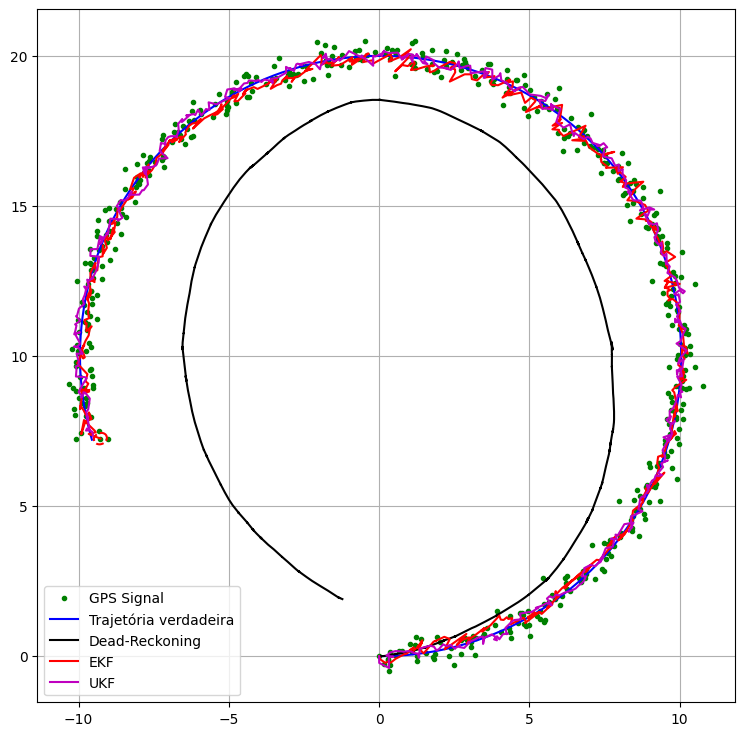

In [ ]:
#Cria partículas distribuídas uniformemente dentro de intervalos especificados para posição (x, y) e orientação (hdg).
#As partículas representam hipóteses potenciais sobre o estado atual do veículo.
def geracao_particulas_uniformes(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def predict(particles, u, std, dt=1.): #Move as partículas com base nos comandos de controle e adiciona ruído para simular incertezas.
    N = len(particles)
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

def update(particles, weights, z, R, landmarks): #Atualiza os pesos das partículas com base na diferença entre as medições reais e esperadas.
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])
    weights += 1.e-300
    weights /= sum(weights) # normaliza os pesos

def neff(weights): #Avalia a eficácia das partículas e decide quando reamostrar.
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes): #Seleciona partículas para manter com base nos seus pesos, focando em áreas de alta probabilidade.
    particles[:] = particles[indexes]
    weights.fill (1.0 / len(weights))

def estimate(particles, weights): #Calcula a média ponderada das partículas para estimar o estado atual.
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var


#Simulação

def main_ukf(): #função principal para a simulação do UKF
    nx = 4  #dimensão do vetor de estado [x y phi v]

    #Inicialização de vetores de estado e covariância
    xEst = np.zeros((nx, 1))
    xTrue = np.zeros((nx, 1))
    PEst = np.eye(nx)

    #Inicialização de parâmetros UKF
    wm, wc, gamma = setup_ukf(nx)

    xDR = np.zeros((nx, 1))  # Dead reckoning

    #Histórico
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))

    time = 0.0

    while SIM_TIME >= time: #loop principal da simulação
        time += dt #avanço no tempo
        u = calc_input() #cálculo da entrada de controle

        xTrue, z, xDR, ud = aquisicao_dados(xTrue, xDR, u, False) #aquisição de dados

        xEst, PEst = ukf_estimativa(xEst, PEst, z, ud, wm, wc, gamma) #estimativa de estado

        #armazenamento de dados
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.vstack((hz, z))
    return hxEst, hxTrue

def main_ekf(seed=False): #função principal para a simulação do EKF
    if seed:
        np.random.seed(seed)
    time = 0.0
    #Vetores de Estado e Matriz de Covariância
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    #Histórico
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hxmu = np.array(xTrue[:2])
    hz = np.zeros((1, 2))

    N = 1000  # Número de partículas

    # Landmarks
    landmarks = np.array([[0, 0],[100, 100],[0, 200],[-100, 100]]) #posição dos landmarks
    NL = len(landmarks) #número de landmarks

    particles = geracao_particulas_uniformes((0,40), (0,40), (0, 6.28), N) #geração de partículas
    weights = np.ones(N) / N  # pesos uniformes

    xs = [] #vetor de estado
    robot_pos = np.array([0., 0.]) #posição inicial do robô
    sensor_std_err = 0.5 #erro padrão do sensor

    while SIM_TIME >= time: #loop principal da simulação
        time += dt #avanço no tempo
        u = calc_input() #cálculo da entrada de controle

        xTrue, z, xDR, ud = aquisicao_dados(xTrue, xDR, u) #aquisição de dados
        xEst, PEst = ekf_estimativa(xEst, PEst, z, ud) #estimativa de estado

        #armazenamento de dados
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.vstack((hz, z))

        robot_pos = z #posição do robô

        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err)) #geração de medições

        #Predizem a próxima posição das partículas com base na entrada de controle e atualizam os pesos das partículas
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        update(particles, weights, z=zs, R=sensor_std_err,
               landmarks=landmarks)

        # se a eficácia das partículas cair abaixo de um certo limiar, reamostra
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)

        hxmu = np.hstack((hxmu, np.array([mu]).T)) #armazena a média das partículas

    hxEst_2, hxTrue_2 = main_ukf() #simulação do UKF

    #Plota as trajetórias verdadeira, estimada pelo EKF, pelo dead reckoning, e pelo UKF, juntamente com as medições de GPS.
    plt.figure(figsize=(9,9))
    plt.plot(hz[:, 0], hz[:, 1], ".g", label="GPS Signal")
    plt.plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b", label="Trajetória verdadeira")
    plt.plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k", label="Dead-Reckoning")
    plt.plot(hxEst[0, :].flatten(), hxEst[1, :].flatten(), "-r", label="EKF")
    plt.plot(hxEst_2[0, :].flatten(), hxEst_2[1, :].flatten(), "-m", label="UKF")

    plot_covariance_ellipse(xEst, PEst)

    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

    return hxEst, hxTrue, hxEst_2, hxTrue_2

hxEst, hxTrue, hxEst_2, hxTrue_2 = main_ekf(5)

In [ ]:
#Cálculo do RMSE (Raiz do erro quadrático médio) para cada filtro
def calculate_rmse(estimations, true_values):
    return np.sqrt(((estimations - true_values) ** 2).mean())

rmse_ekf = calculate_rmse(hxEst[:2, :], hxTrue[:2, :])
rmse_ukf = calculate_rmse(hxEst_2[:2, :], hxTrue_2[:2, :])

rmse_ekf, rmse_ukf

(0.1832087508822769, 0.13582763074304086)

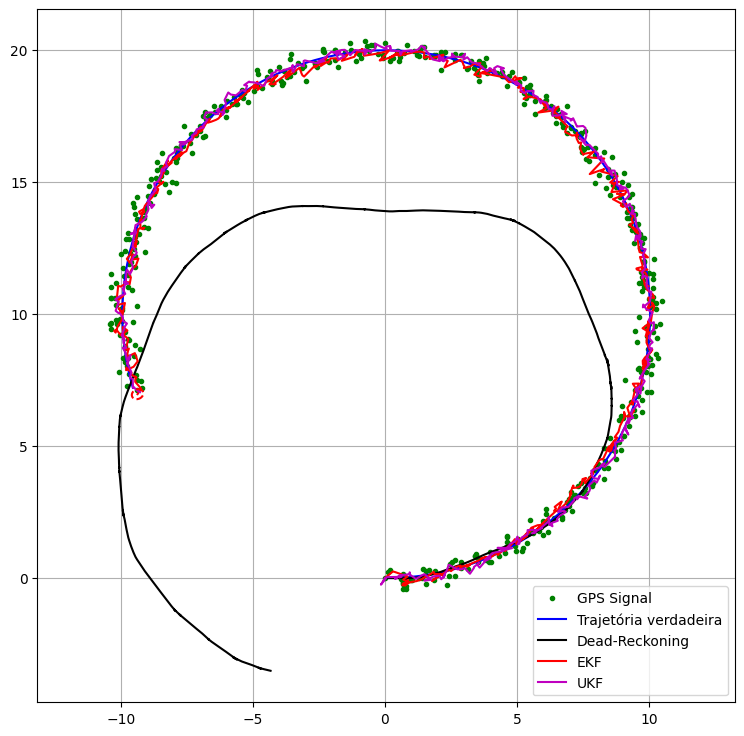

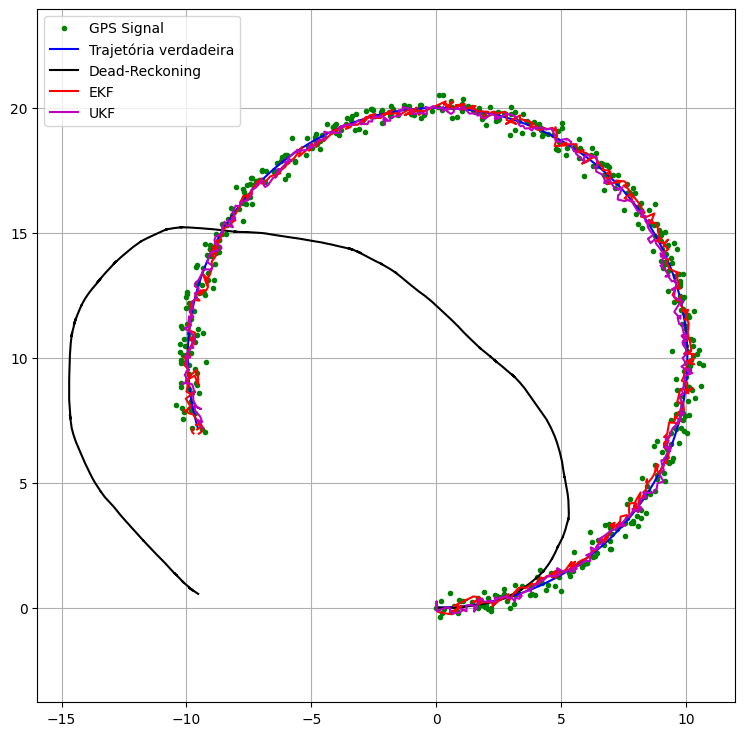

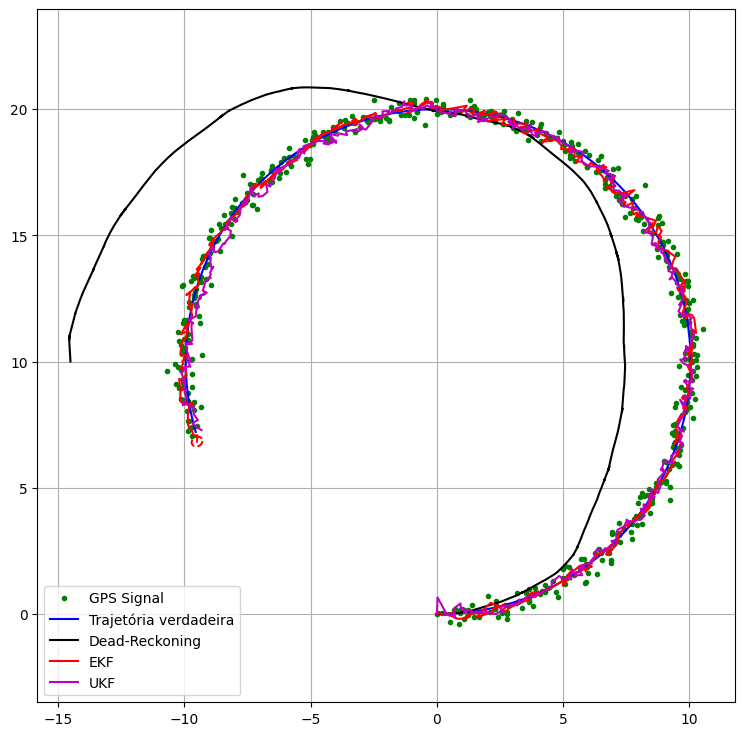

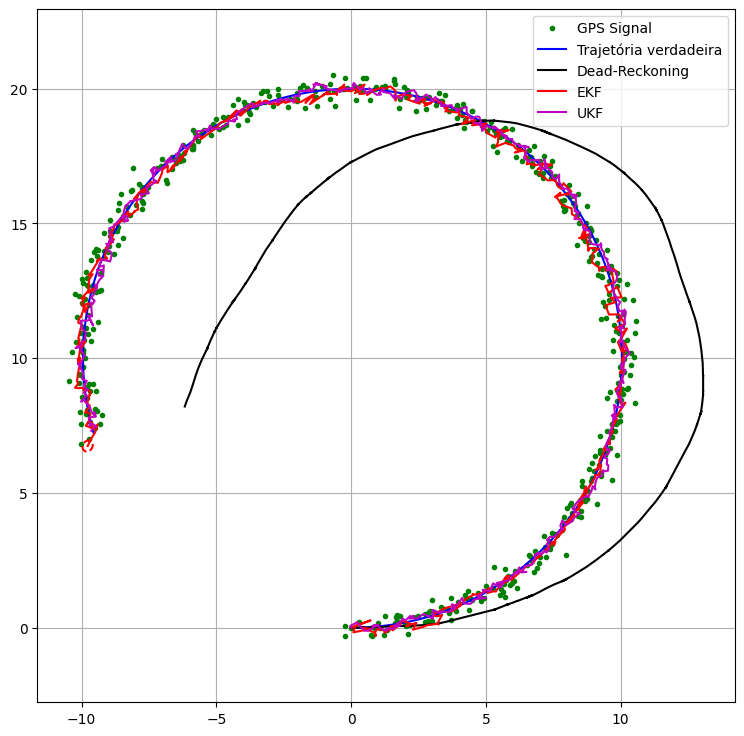

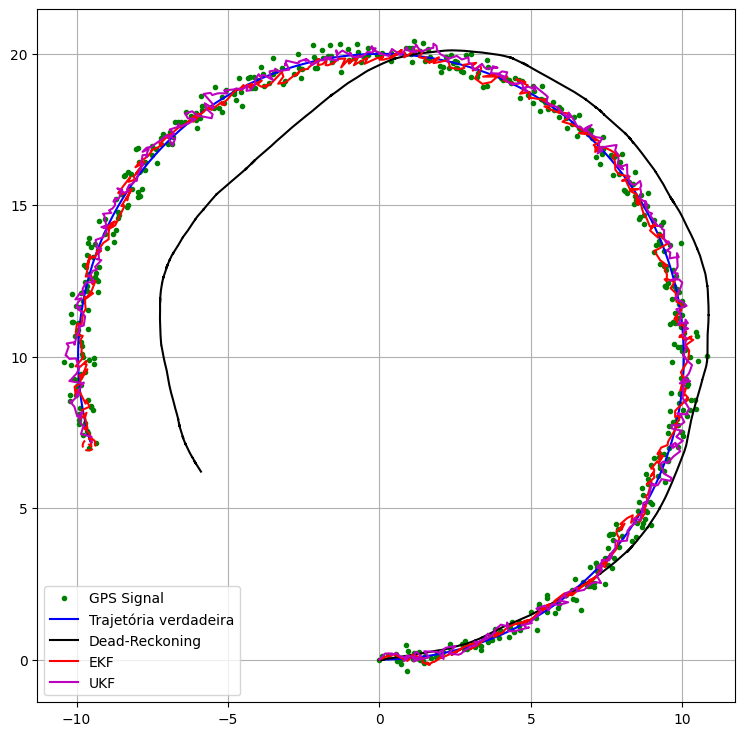

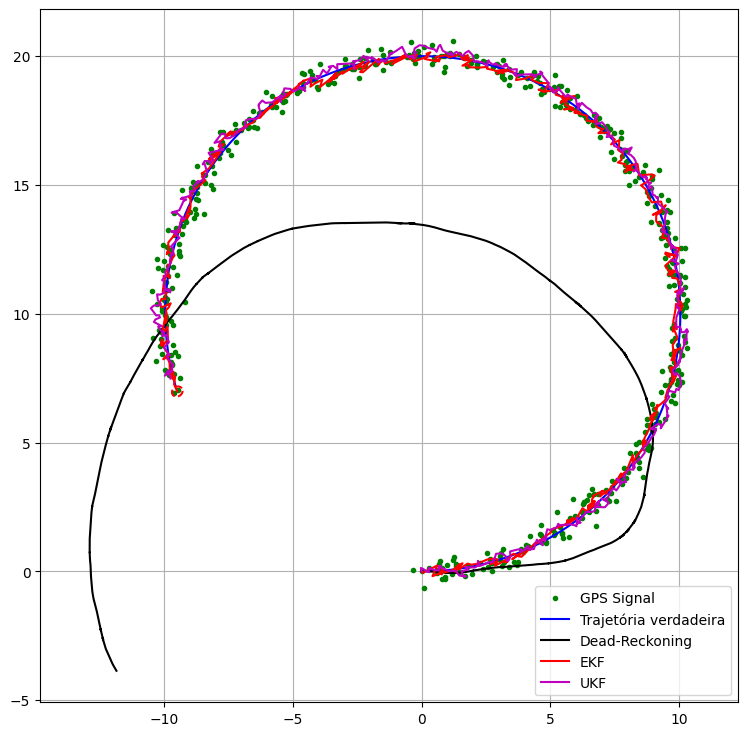

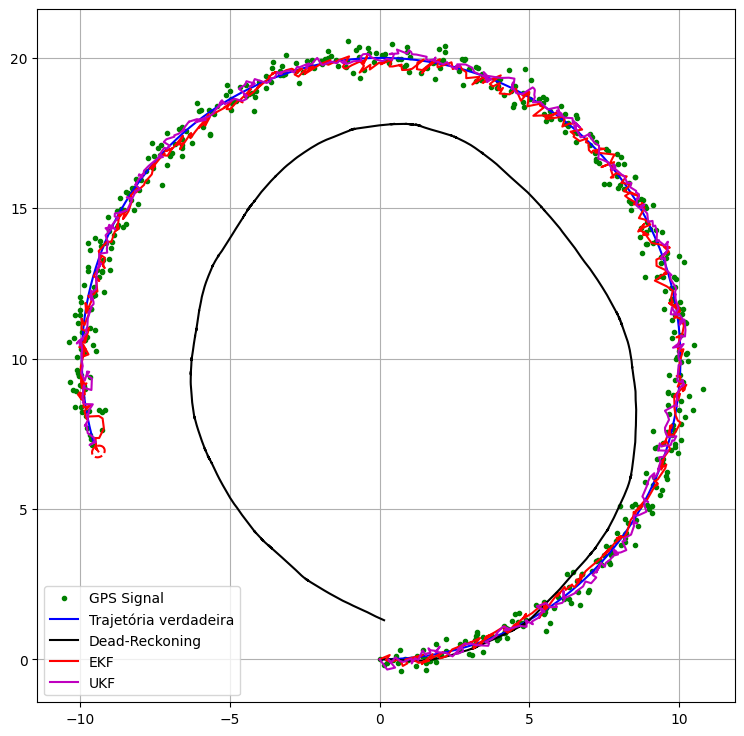

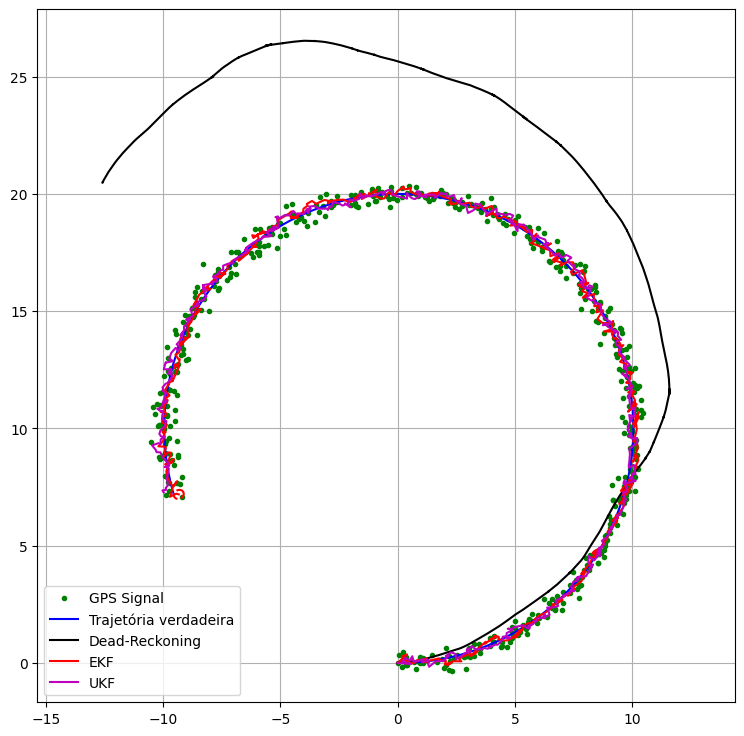

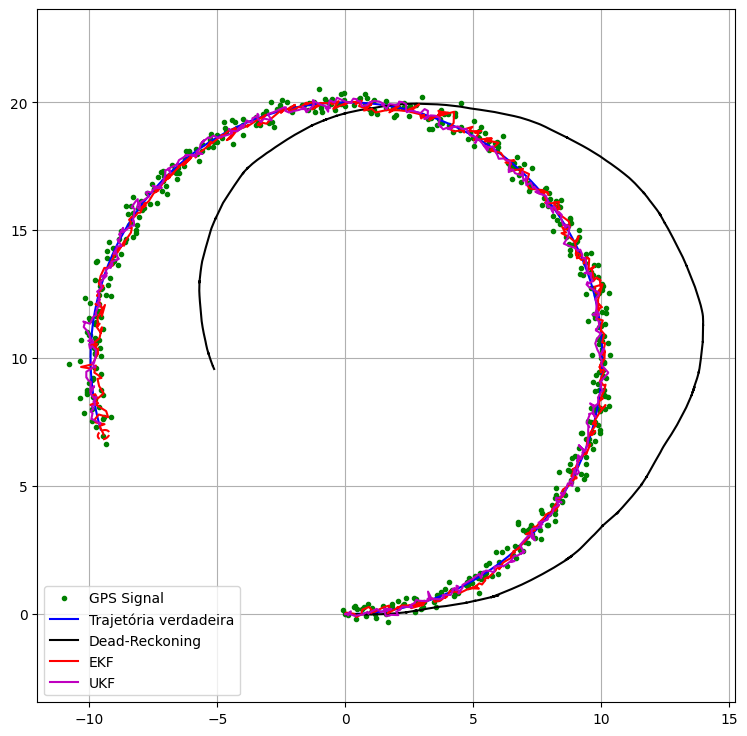

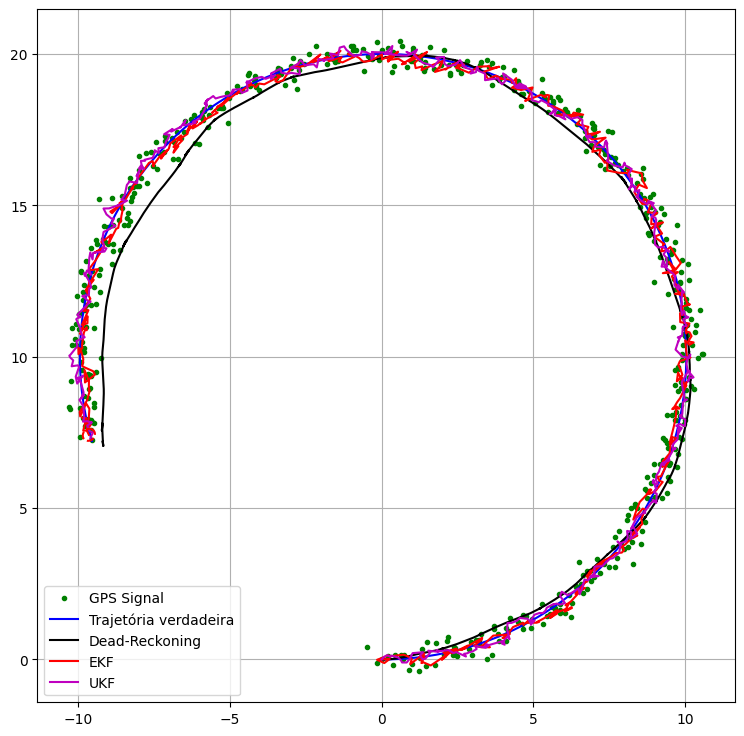

(0.1833418473349294, 0.14523498467013715)

In [ ]:
def simulate():
    # Executa uma simulação individual e retorna os RMSEs para EKF e UKF
    hxEst, hxTrue, hxEst_2, hxTrue_2 = main_ekf()
    rmse_ekf = calculate_rmse(hxEst[:2, :], hxTrue[:2, :])
    rmse_ukf = calculate_rmse(hxEst_2[:2, :], hxTrue_2[:2, :])
    return rmse_ekf, rmse_ukf

# Inicializa listas para armazenar os resultados de RMSE
rmse_ekf_results = []
rmse_ukf_results = []

# Realiza 10 simulações
for _ in range(10):
    rmse_ekf, rmse_ukf = simulate()
    rmse_ekf_results.append(rmse_ekf)
    rmse_ukf_results.append(rmse_ukf)

# Calcula a média dos RMSEs para cada filtro
mean_rmse_ekf = np.mean(rmse_ekf_results)
mean_rmse_ukf = np.mean(rmse_ukf_results)

mean_rmse_ekf, mean_rmse_ukf


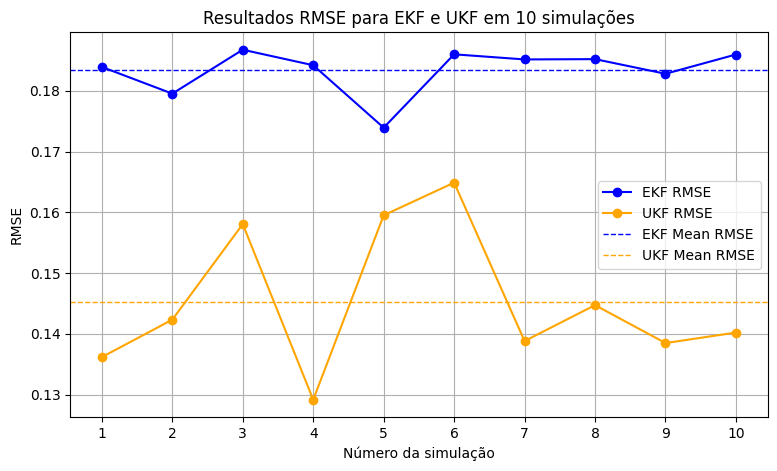

Média RMSE EKF: 0.1833418473349294
Média RMSE UKF: 0.14523498467013715


In [ ]:
plt.figure(figsize=(9, 5))

simulations_index = np.arange(1, 11)  # 10 simulações

plt.plot(simulations_index, rmse_ekf_results, '-o', label='EKF RMSE', color='blue')
plt.plot(simulations_index, rmse_ukf_results, '-o', label='UKF RMSE', color='orange')

# Calculando as médias dos RMSEs para EKF e UKF com base nos resultados reais
mean_rmse_ekf = np.mean(rmse_ekf_results)  # Média dos RMSEs para EKF
mean_rmse_ukf = np.mean(rmse_ukf_results)  # Média dos RMSEs para UKF

# Plotando as médias
plt.axhline(mean_rmse_ekf, color='blue', linestyle='dashed', linewidth=1, label='EKF Mean RMSE')
plt.axhline(mean_rmse_ukf, color='orange', linestyle='dashed', linewidth=1, label='UKF Mean RMSE')

plt.title('Resultados RMSE para EKF e UKF em 10 simulações')
plt.xlabel('Número da simulação')
plt.ylabel('RMSE')
plt.xticks(simulations_index)
plt.legend()
plt.grid(True)
plt.show()

# Exibindo as médias de RMSE para referência
print("Média RMSE EKF:", mean_rmse_ekf)
print("Média RMSE UKF:", mean_rmse_ukf)

# Discussão

**Filtro de Kalman Estendido (EKF)**

É uma versão do Filtro de Kalman tradicional que permite tratar sistemas não lineares. O Filtro de Kalman é um algoritmo recursivo usado para estimar o estado de um sistema dinâmico linear a partir de uma série de medições ruidosas.

**Passo a passo para implementação do EKF**
* Modelo Dinâmico (modelo_dinamico)
Predição do Estado: Usa o modelo de transição de estado para prever o próximo estado do sistema com base no estado atual e na entrada de controle. Este modelo é uma parte fundamental da etapa de Predição do EKF.

* Modelo de Observação (modelo_observacao)
Modelo de Medição: Relaciona o estado do sistema com a medição esperada, fundamental para a etapa de Atualização do EKF, onde as previsões são comparadas com as medições reais.

* Aquisição de Dados (aquisicao_dados)
Medição com Ruído: Simula a obtenção de medições reais adicionando ruído ao verdadeiro estado do sistema. Esse processo não é parte direta do EKF, mas é essencial para testá-lo em condições realistas.

* Estimativa EKF (ekf_estimation)

 * Linearização do Modelo de Transição e Medição: Usa as funções jacobA (para o modelo de transição) e jacobC (para o modelo de observação) para calcular as Jacobianas, que são necessárias para linearizar os modelos não lineares ao redor do ponto de operação atual. Essas funções correspondem à linearização necessária no EKF.

  * Predição: Calcula a predição do próximo estado (xPred) e da covariância do erro de predição (pPred) com base no estado e covariância estimados, usando o modelo de transição e a matriz Jacobiana do modelo de transição.

  * Atualização: Com base na medição atual (z), atualiza o estado estimado (xEst) e a covariância do erro estimado (PEst) usando o modelo de observação, a matriz Jacobiana do modelo de observação, o ganho de Kalman (K), e a diferença entre a medição real e a predição da medição.

**Resultado obtido**
A média do RMSE para o EKF é aproximadamente 0.1833

**Filtro de Kalman Unscented (UKF)**

É uma abordagem para estimar o estado de sistemas dinâmicos não lineares que pode oferecer vantagens sobre o Filtro de Kalman Estendido (EKF) em termos de precisão, especialmente em sistemas com não linearidades fortes.

**Passo a passo para implementação do UKF**
* Seleção dos Pontos Sigma (generate_sigma_points)
A função generate_sigma_points calcula os pontos sigma com base no estado estimado atual (xEst) e na covariância do estado (PEst). Isso corresponde à etapa de Seleção dos Pontos Sigma do UKF.

* Transformação Unscented
  * Propagação dos Pontos Sigma: A função predict_sigma_motion aplica o modelo dinâmico aos pontos sigma para prever seu próximo estado. Este passo é equivalente à Propagação dos Pontos Sigma através da função de processo não linear do UKF.

  * Atualização da Média e Covariância do Estado Previsto: Embora não explicitamente separada em uma função distinta, a recombinação dos pontos sigma propagados para calcular a média e covariância do estado previsto (xPred,PPred) é realizada dentro de ukf_estimation após a chamada a predict_sigma_motion. Isso atende à parte de Atualização da Média e Covariância da etapa de Transformação Unscented para a predição do estado.

* Atualização com Medição
  * Transformação dos Pontos Sigma Através da Função de Medição: A função predict_sigma_observation transforma os pontos sigma propagados usando o modelo de observação, correspondendo à Transformação dos Pontos Sigma Através da Função de Medição do UKF.

  * Cálculo da Média e Covariância da Medição Prevista e Ganho de Kalman: A partir dos pontos sigma transformados pela função de observação, ukf_estimation calcula a média e covariância das medições previstas (zPred, st), bem como o ganho de Kalman (K t). Esses cálculos são partes essenciais da Atualização com Medição no UKF.

  * Atualização do Estado e da Covariância com Medição: Finalmente, ukf_estimation atualiza o estado estimado (xEst) e a covariância (PEst) com base na diferença entre a medição real e a medição prevista, utilizando o ganho de Kalman. Este é o último passo da Atualização com Medição no UKF.


**Resultado obtido**
A média do RMSE para o UKF é aproximadamente 0.1452.

**Comparação e conclusão**

O UKF teve um desempenho significativamente melhor do que o EKF em termos de precisão das estimativas em relação à trajetória verdadeira. Isso é consistente com o entendimento geral de que o UKF pode oferecer melhorias em precisão sobre o EKF para problemas não-lineares, devido à sua capacidade de melhor capturar a distribuição de probabilidade da estimativa do estado através do uso de pontos sigma.

Um RMSE menor para o UKF em comparação com o EKF sugere que o UKF foi mais eficaz em lidar com as não-linearidades do seu sistema. Esses resultados são realistas e esperados, especialmente em sistemas com fortes não-linearidades ou quando o modelo de processo ou de medição é complexo.

Além disso, a diferença nos valores de RMSE ressalta a importância do ajuste dos parâmetros Q (matriz de covariância do processo) e R (matriz de covariência da observação). Estes parâmetros são cruciais pois influenciam diretamente na confiança do filtro em relação às medições e ao modelo de processo, de forma que valores muito baixos de Q significam alta confiança no modelo do processo, subestimando o ruído, já um valor muito alto indica que é esperado uma incerteza maior no processo, em relação aos valores de R, um maior valor indica que se espera mais ruído ou maiores erros na medição, por outro lado, valores menores indicam alta confiança nas medições, portanto, a correta seleção desses parâmetros é essencial para otimizar o desempenho dos filtros.

Através do ajuste de Q e R, os filtros podem ser otimizados para melhor se adaptarem à sua aplicação. Os resultados obtidos com o UKF reforçam a sua viabilidade em contextos práticos não-lineares, e destacam o valor de uma calibração adequada dos parâmetros do filtro.